In [2]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
SI_FIGURE_OUTDIR = '../figures/si figures'

######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


In [3]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive = (df_clean.Immune_All_Low_predicted_labels == 'Naive B cells')
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
unhypermutated = df_clean.v_mismatch < 1
# print(df_clean.celltype.value_counts())
# df_clean.loc[naive & (df_clean.v_mismatch > 0), 'celltype'] = 'Memory B cells'
# print(df_clean.celltype.value_counts())

permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]


In [4]:
lineage_sizes = df.groupby(['donor', 'lineage_id'])['vdj_sequence'].nunique()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],axis=1)
df_clean['is_naive_for_lineage_designation'] = (df_clean['celltype'] == 'Naive B cells') & (df_clean.v_mismatch < 1)
naive_lineage = df_clean.groupby(['donor', 'lineage_id'])['is_naive_for_lineage_designation'].sum() > 1
df_clean['naive_lineage'] = df_clean.apply(lambda x: naive_lineage[(x.donor, x.lineage_id)],axis=1)

### infer long-term exit rate from v_mismatch distribution among all common differentiated cell types

In [5]:
celltype_counts = df_clean.celltype.value_counts()
common_celltype = df_clean.celltype.map(celltype_counts) > 100
df_clean = df_clean[common_celltype]
celltype_counts = df_clean.celltype.value_counts()
df_hm_clean = df_clean[df_clean.v_mismatch>0]
df_hm_clean = df_hm_clean[~df_hm_clean.celltype.isin(['ABCs', 'GC B cells'])]

all_cell_v_mismatch = df_clean.v_mismatch.values
all_v_mismatch = df_hm_clean.v_mismatch.values

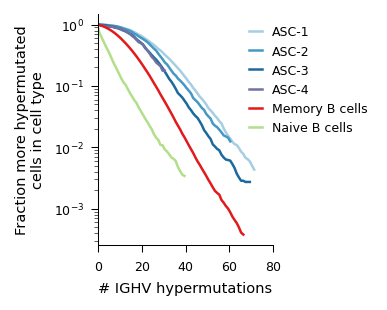

In [6]:
fig, ax = plt.subplots(figsize=(1.5, 2))

for ct in sorted(df_hm_clean.celltype.unique()):


    data_distribution = df_hm_clean[(df_hm_clean.celltype==ct)].v_mismatch.values
    data_distribution, bins = np.histogram(data_distribution, bins = np.arange(0,max(all_v_mismatch+2))-0.5)
    data_distribution = data_distribution/data_distribution.sum()
    norm20 = data_distribution[:20].sum()
    data_distribution  = data_distribution
    data_ccdf = 1 - data_distribution.cumsum()

    total_cells = len(df_hm_clean[df_hm_clean.celltype==ct].v_mismatch.values)

    cutoff = np.argwhere(data_ccdf < 20/total_cells)[0][0]

    ax.plot(bins[:cutoff], data_ccdf[:cutoff], label=ct, color=bcelltype_colors_alt[ct], lw=1.2)    
ax.legend(loc='upper left', bbox_to_anchor=(0.8,1), handlelength=1, frameon=False)
ax.set_yscale('log')
ax.set_xlim([0,80])
ax.set_xlabel('# IGHV hypermutations')
ax.set_ylabel('Fraction more hypermutated\ncells in cell type')
sns.despine(fig)

fig.savefig(f'{FIGURE_OUTDIR}/Figure4/common_celltype_hypermutation_distribution.pdf', bbox_inches='tight')

In [7]:
## Now fit to tail of distribution of differentiated cells
df_hm_clean = df_hm_clean[~df_hm_clean.celltype.isin(['ABCs', 'GC B cells', 'Naive B cells'])]


In [8]:
from sklearn.linear_model import LinearRegression

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_19830/2286039467.py:20: RuntimeWarning: invalid value encountered in log
  log_data_ccdf = np.log(data_ccdf)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_19830/2286039467.py:20: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(data_ccdf)


ASC-1 0.02951111401690265 -1.9121554627864534
ASC-2 0.029340991601123245 -1.6440467214989671
ASC-3 0.033148678908442086 -1.6399998912736105
ASC-4 0.029474461946751518 -1.3075514063483127
Memory B cells 0.04098848033710778 -1.3842362794066778


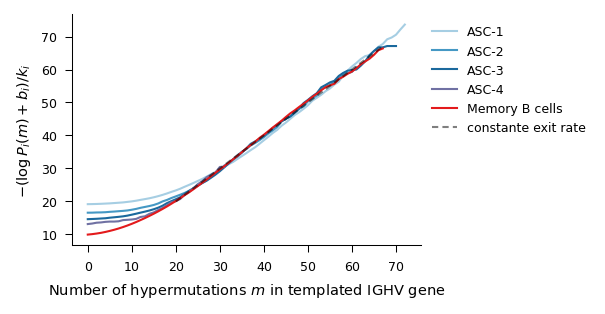

In [9]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
V=0.3
parameter_dict = {'state':[],'slope':[], 'rate':[], 'offset':[]}

bins = np.arange(0,max(all_v_mismatch+2))-0.5
bin_centers = (bins[1:] + bins[:-1])/2

p_celltype = pd.DataFrame(index=bin_centers)

fractional_excess_dict = {}
for ct in sorted(df_hm_clean.celltype.unique()):


    data_distribution = df_hm_clean[(df_hm_clean.celltype==ct)].v_mismatch.values
    data_distribution, bins = np.histogram(data_distribution, bins = np.arange(0,max(all_v_mismatch+2))-0.5)
    data_distribution = data_distribution/data_distribution.sum()
    norm20 = data_distribution[:20].sum()
    data_distribution  = data_distribution
    data_ccdf = 1 - data_distribution.cumsum()
    log_data_ccdf = np.log(data_ccdf)

    total_cells = len(df_hm_clean[df_hm_clean.celltype==ct].v_mismatch.values)
    if ct == 'Naive B cells':
        begin = 2
    else:
        begin = 20
    cutoff = np.argwhere(log_data_ccdf < np.log(20/total_cells))[0][0]
    
    
    X=bin_centers[begin:cutoff].reshape(-1, 1)
    Y = -log_data_ccdf[begin:cutoff].reshape(-1, 1)
    reg = LinearRegression().fit(X,Y)
    # print(reg.score(X, Y))
    b = reg.coef_[0][0]
    a = reg.intercept_[0]
    print(ct, 1 - np.exp(-V*b), a)
    parameter_dict['state'].append(ct)
    parameter_dict['slope'].append(b)
    parameter_dict['offset'].append(a)
    parameter_dict['rate'].append( 1 - np.exp(-V*b))
    
    ax.plot(bin_centers[:cutoff], (-log_data_ccdf[:cutoff]-a)/b, color=bcelltype_colors_alt[ct], label=ct)
    
    observed = data_distribution[:cutoff]
    model = np.exp(-b*bin_centers[:cutoff]-a)*b

    # observed = observed[:-1] + observed[1:]
    # model = model[1:] + model[:-1]
    fractional_excess_dict[ct] = observed/model

    p_celltype[ct] = total_cells* b * np.exp(-b*bin_centers-a)
line1, = ax.plot(X,X, color='k', alpha=0.5, label='constante exit rate')
line1.set_dashes((3,2))
# fig.tight_layout()

ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax.set_xlabel('Number of hypermutations $m$ in templated IGHV gene', fontsize=7)
ax.set_ylabel(r'$-(\log P_i(m)+b_i)/k_i$')
fig.savefig(f'{SI_FIGURE_OUTDIR}/long_term_exit_rate_fit.pdf', bbox_inches='tight')


In [10]:
max_len = max(len(v) for k, v in fractional_excess_dict.items())
for k, v in fractional_excess_dict.items():
    n_pad = max_len - len(v)
    fractional_excess_dict[k] = np.pad(v, (0,n_pad), constant_values=(0,np.nan))
fractional_excess_df = pd.DataFrame(fractional_excess_dict)
fractional_excess_df['bin_center'] = (0.5*(bin_centers[:-1] + bin_centers[1:]))[:max_len]
fractional_excess_df = fractional_excess_df.set_index('bin_center')
mean_fractional_excess = fractional_excess_df.mean(axis=1)

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_19830/2694997497.py:20: RuntimeWarning: invalid value encountered in log
  log_data_ccdf = np.log(data_ccdf)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_19830/2694997497.py:20: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(data_ccdf)


ASC-1 0.02951111401690265 -1.9121554627864534
ASC-2 0.029340991601123245 -1.6440467214989671
ASC-3 0.033148678908442086 -1.6399998912736105
ASC-4 0.029474461946751518 -1.3075514063483127
Memory B cells 0.04098848033710778 -1.3842362794066778
../figures/paper figures/Figure4/constant_exit_rate_repertoire_wide.pdf


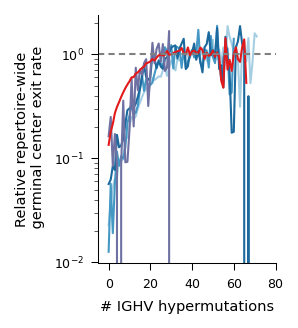

In [49]:
fig, ax = plt.subplots(1,1, figsize=(2,2.2))
V=0.3
parameter_dict = {'state':[],'slope':[], 'rate':[], 'offset':[]}

bins = np.arange(0,max(all_v_mismatch+2))-0.5
bin_centers = (bins[1:] + bins[:-1])/2

p_celltype = pd.DataFrame(index=bin_centers)

fractional_excess_dict = {}
for ct in sorted(df_hm_clean.celltype.unique()):


    data_distribution = df_hm_clean[(df_hm_clean.celltype==ct)].v_mismatch.values
    data_distribution, bins = np.histogram(data_distribution, bins = np.arange(0,max(all_v_mismatch+2))-0.5)
    data_distribution = data_distribution/data_distribution.sum()
    norm20 = data_distribution[:20].sum()
    data_distribution  = data_distribution
    data_ccdf = 1 - data_distribution.cumsum()
    log_data_ccdf = np.log(data_ccdf)

    total_cells = len(df_hm_clean[df_hm_clean.celltype==ct].v_mismatch.values)
    if ct == 'Naive B cells':
        begin = 2
    else:
        begin = 20
    cutoff = np.argwhere(log_data_ccdf < np.log(20/total_cells))[0][0]
    
    X=bin_centers[begin:cutoff].reshape(-1, 1)
    Y = -log_data_ccdf[begin:cutoff].reshape(-1, 1)
    reg = LinearRegression().fit(X,Y)
    # print(reg.score(X, Y))
    b = reg.coef_[0][0]
    a = reg.intercept_[0]
    print(ct, 1 - np.exp(-V*b), a)
    parameter_dict['state'].append(ct)
    parameter_dict['slope'].append(b)
    parameter_dict['offset'].append(a)
    parameter_dict['rate'].append( 1 - np.exp(-V*b))
    
    long_term = b
    ax.plot(bin_centers[:cutoff-1], np.diff(-log_data_ccdf[:cutoff])/long_term, color=bcelltype_colors_alt[ct], label=ct)

    ax.set_yscale('log')
line1.set_dashes((3,2))
fig.tight_layout()
line1= ax.axhline(y=1, color='0.5')
line1.set_dashes((3,2))
# ax[1].set_ylim([0.1,10])
ax.set_xlim([-5,80])
ax.set_xticks([0,20,40,60,80])
# ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax.set_xlabel('# IGHV hypermutations', fontsize=7)
ax.set_ylabel('Relative repertoire-wide\n germinal center exit rate')
fig.tight_layout()

fig.savefig(f'{FIGURE_OUTDIR}/Figure4/constant_exit_rate_repertoire_wide.pdf', bbox_inches='tight')
print(f'{FIGURE_OUTDIR}/Figure4/constant_exit_rate_repertoire_wide.pdf')



/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/2737587548.py:19: RuntimeWarning: invalid value encountered in log
  log_data_ccdf = np.log(data_ccdf)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/2737587548.py:19: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(data_ccdf)


ASC-1 20 73
ASC-1 0.02951111401690265 -1.9121554627864534
ASC-2 20 62
ASC-2 0.029340991601123245 -1.6440467214989671
ASC-3 20 71
ASC-3 0.033148678908442086 -1.6399998912736105
ASC-4 20 32
ASC-4 0.029474461946751518 -1.3075514063483127
Memory B cells 20 68
Memory B cells 0.04098848033710778 -1.3842362794066778
../figures/paper figures/Figure4/constant_exit_rate_repertoire_wide.pdf


,ASC-1,ASC-2,ASC-3,ASC-4,Memory B cells
0.0,3891.692105,820.558361,4662.033929,45.718187,38158.107278
1.0,3521.873024,743.016469,4166.529040,41.378895,33189.412983
2.0,3187.197050,672.802203,3723.688953,37.451462,28867.708928
3.0,2884.324610,609.223110,3327.916183,33.896798,25108.748359
4.0,2610.233483,551.652174,2974.208174,30.679520,21839.254571
...,...,...,...,...,...
92.0,0.398638,0.088694,0.150967,0.004738,0.101756
93.0,0.360756,0.080313,0.134921,0.004288,0.088506
94.0,0.326474,0.072723,0.120581,0.003881,0.076981
95.0,0.295450,0.065851,0.107765,0.003513,0.066957


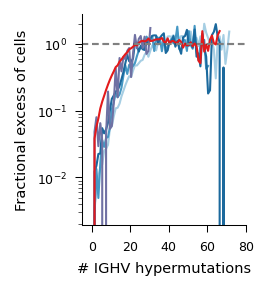

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1.75,1.8), sharex=True)
V=0.3
parameter_dict = {'state':[],'slope':[], 'rate':[], 'offset':[]}

bins = np.arange(0,max(all_v_mismatch+2))-0.5
bin_centers = (bins[1:] + bins[:-1])/2

p_celltype = pd.DataFrame(index=bin_centers)

for ct in sorted(df_hm_clean.celltype.unique()):


    data_distribution = df_hm_clean[(df_hm_clean.celltype==ct)].v_mismatch.values
    data_distribution, bins = np.histogram(data_distribution, bins = np.arange(0,max(all_v_mismatch+2))-0.5)
    data_distribution = data_distribution/data_distribution.sum()
    norm20 = data_distribution[:20].sum()
    data_distribution  = data_distribution
    data_ccdf = 1 - data_distribution.cumsum()
    log_data_ccdf = np.log(data_ccdf)

    total_cells = len(df_hm_clean[df_hm_clean.celltype==ct].v_mismatch.values)
    if ct == 'Naive B cells':
        begin = 2
    else:
        begin = 20
    cutoff = np.argwhere(log_data_ccdf < np.log(20/total_cells))[0][0]
    print(ct, begin, cutoff)
    
    
    X=bin_centers[begin:cutoff].reshape(-1, 1)
    Y = -log_data_ccdf[begin:cutoff].reshape(-1, 1)
    reg = LinearRegression().fit(X,Y)
    # print(reg.score(X, Y))
    b = reg.coef_[0][0]
    a = reg.intercept_[0]
    print(ct, 1 - np.exp(-V*b), a)
    parameter_dict['state'].append(ct)
    parameter_dict['slope'].append(b)
    parameter_dict['offset'].append(a)
    parameter_dict['rate'].append( 1 - np.exp(-V*b))
    

    ax.set_ylabel('Fractional excess of cells')
    # ax[1].set_ylabel('Fractional excess \nrelative to mean rate')

    if ct == "Naive B cells":
        pass
    else:
        pass
    xs = (bin_centers[1:] + bin_centers[:-1])/2.
    xs = xs[:cutoff-1]
    
    ax.plot(xs, fractional_excess_df[ct][:cutoff-1], color=bcelltype_colors_alt[ct], label=ct)
    ax.plot(xs, -log_data_ccdf[:cutoff-1], color=bcelltype_colors_alt[ct], label=ct)
    p_celltype[ct] = total_cells* b * np.exp(-b*bin_centers-a)
line1, = ax.plot(bin_centers,np.ones(len(bin_centers)), color='k', alpha=0.5, label='model')
line1.set_dashes((3,2))
fig.tight_layout()

# ax[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax.set_yscale('log')
ax.set_xlabel('', fontsize=7)
ax.set_xlabel('# IGHV hypermutations', fontsize=7)
# ax.set_ylabel('Fraction more hypermutated\ncells in celltype')
line1= ax.axhline(y=1, color='0.5')
line1.set_dashes((3,2))
# ax[1].set_ylim([0.1,10])
ax.set_xlim([-5,80])
ax.set_xticks([0,20,40,60,80])
# fig.tight_layout()

rate_dict = pd.DataFrame(parameter_dict).set_index('state')
p_celltype

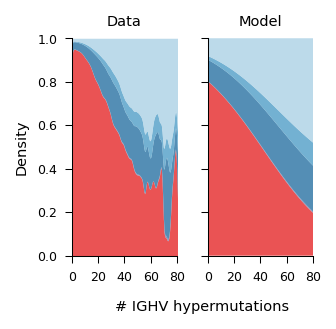

In [ ]:
p_celltype_norm = (p_celltype.T/p_celltype.sum(axis=1)).T#.reset_index()

sorted_columns = sorted(p_celltype_norm.columns)[::-1]
p_celltype_norm = p_celltype_norm[sorted_columns]
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(2.25,2.))


ax[1].stackplot(p_celltype_norm.index, p_celltype_norm.T,colors=[bcelltype_colors_alt[x] for x in p_celltype_norm.columns], labels = p_celltype_norm.columns, alpha=0.75)
# ax[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
g = sns.kdeplot(data=df_hm_clean.sort_values('celltype'), x='v_mismatch', hue='celltype', palette=bcelltype_colors_alt, multiple='fill', lw=0, ax = ax[0], legend=False)
# sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlim([0,80])
ax[0].set_xticks([0,20,40,60,80])
ax[0].set_title('Data', fontsize=7)
ax[1].set_title('Model', fontsize=7)
fig.tight_layout()
fig.supxlabel('# IGHV hypermutations', fontsize=7, x = 0.6, y = -0.05)
fig.savefig(f'{FIGURE_OUTDIR}/Figure4/stacked_density_celltype_data_vs_constant_rate.pdf', bbox_inches='tight')


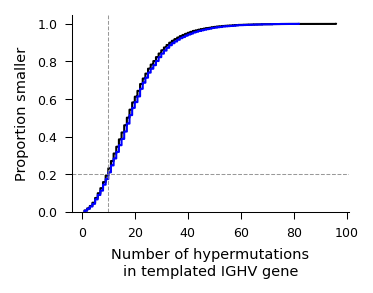

In [54]:
fig, ax=plt.subplots(figsize=(2.5,2))

sns.ecdfplot(df_hm_clean[(df_hm_clean.lineage_size>2)],x = 'v_mismatch', color='k', complementary=False, lw=1)

# ax.set_yscale('log')
ax.axvline(x=10, color='0.5', alpha=0.8, linestyle='dashed', lw=0.5)
ax.axhline(y=0.2, color='0.5', alpha=0.8, linestyle='dashed', lw=0.5)
ax.set_xlabel('Number of hypermutations\nin templated IGHV gene', fontsize=7)
ax.set_ylabel('Proportion smaller')
sns.despine(fig)
fig.tight_layout()
ax.set_ylim([0,1.05])
fig.savefig(f'{SI_FIGURE_OUTDIR}/marginal_hm_m_distribution.pdf', bbox_inches='tight')

False    74460
True       465
Name: has_naive, dtype: int64


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/1331659066.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_abundance = lineage_composition.groupby(['binned_total', 'has_naive']).median().reset_index()
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/1331659066.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_permuted_abundance = lineage_composition_permuted.groupby(['binned_total', 'has_naive']).median().reset_index()


ASC-1
ASC-2
ASC-3
ASC-4
Naive B cells
Memory B cells
ABCs


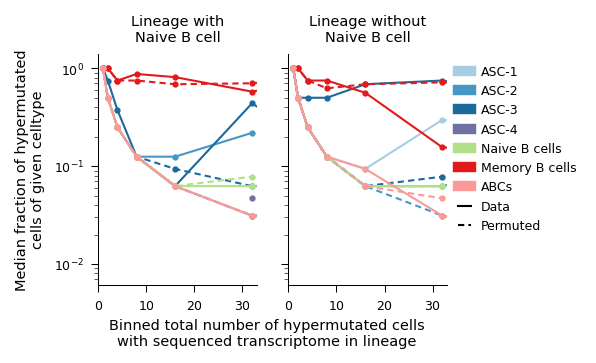

In [ ]:
lineage_composition = df_clean[df_clean.v_mismatch > 0].groupby(['donor','lineage_id','celltype','vdj_sequence']).size().reset_index()
lineage_composition = lineage_composition.groupby(['donor','lineage_id','celltype'])['vdj_sequence'].nunique().reset_index()
lineage_composition = lineage_composition.pivot(index = ['lineage_id', 'donor'], columns = 'celltype', values='vdj_sequence')
lineage_composition['total'] = lineage_composition.sum(axis=1)
lineage_composition['binned_total'] = 2**np.round(np.log(lineage_composition.total)/np.log(2))
lineage_composition = lineage_composition.reset_index()
lineage_composition['has_naive'] = lineage_composition.reset_index().apply(lambda x: naive_lineage[(x.donor, x.lineage_id)], axis=1)
print(lineage_composition.has_naive.value_counts())

lineage_composition_permuted = df_clean[df_clean.v_mismatch > 0].groupby(['donor','lineage_id','celltype','vdj_sequence']).size().reset_index()
lineage_composition_permuted['permuted_celltype'] = np.random.permutation(lineage_composition_permuted['celltype'].values)
lineage_composition_permuted = lineage_composition_permuted.groupby(['donor','lineage_id','permuted_celltype'])['vdj_sequence'].nunique().reset_index()

lineage_composition_permuted = lineage_composition_permuted.pivot(index = ['lineage_id', 'donor'], columns = 'permuted_celltype', values='vdj_sequence')
lineage_composition_permuted['total'] = lineage_composition_permuted.sum(axis=1)
lineage_composition_permuted['binned_total'] = 2**np.round(np.log(lineage_composition_permuted.total)/np.log(2))
lineage_composition_permuted = lineage_composition_permuted.reset_index()

lineage_composition_permuted['has_naive'] = lineage_composition_permuted.reset_index().apply(lambda x: naive_lineage[(x.donor, x.lineage_id)], axis=1)
fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(3,2))
ax_naive_lineage = axes[0]
ax_nonnaive = axes[1]
ax_naive_lineage.set_yscale('log')
ax_naive_lineage.set_xlim([0,33])


mean_abundance = lineage_composition.groupby(['binned_total', 'has_naive']).median().reset_index()
mean_permuted_abundance = lineage_composition_permuted.groupby(['binned_total', 'has_naive']).median().reset_index()
axes[0].set_title('Lineage with\nNaive B cell')
axes[1].set_title('Lineage without\nNaive B cell')
for col in ['ASC-1','ASC-2','ASC-3','ASC-4','Naive B cells', 'Memory B cells','ABCs']:
    if col in bcelltype_colors_alt.keys():
        print(col)
        mean_abundance[col] = mean_abundance[col]/mean_abundance['binned_total']
        ax_naive_lineage.plot(mean_abundance.loc[mean_abundance.has_naive, 'binned_total'], 
                  mean_abundance.loc[mean_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        ax_nonnaive.plot(mean_abundance.loc[~mean_abundance.has_naive, 'binned_total'], 
                  mean_abundance.loc[~mean_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        

        mean_permuted_abundance[col] = mean_permuted_abundance[col]/mean_permuted_abundance['binned_total']
        line1,  = ax_naive_lineage.plot(mean_permuted_abundance.loc[mean_permuted_abundance.has_naive, 'binned_total'], 
                  mean_permuted_abundance.loc[mean_permuted_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        line2,  = ax_nonnaive.plot(mean_permuted_abundance.loc[~mean_permuted_abundance.has_naive, 'binned_total'], 
                  mean_permuted_abundance.loc[~mean_permuted_abundance.has_naive, col], 'o-', markersize=2,
                  color=bcelltype_colors_alt[col], lw=1.)
        line1.set_dashes((3,2))
        line2.set_dashes((3,2))

        axes[1].plot([],[],lw=5,color=bcelltype_colors_alt[col], label=col)

        # ax_naive_lineage.plot(np.logspace(0,5,base=2), 1/np.logspace(0,5,base=2), color='k')
        # if col != 'Naive B cells':
            # sns.lineplot(mean_abundance[~mean_abundance.has_naive], x = 'binned_total', y = col, color=bcelltype_colors_alt[col], ax = ax[0], linestyle='dotted')
sns.despine(fig)
axes[1].plot([],[], lw=1, color='k', label='Data')
line1,  = axes[1].plot([],[], lw=1, color='k', label='Permuted')
line1.set_dashes((3,2))
axes[1].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left', handlelength=1)
fig.supxlabel('Binned total number of hypermutated cells\nwith sequenced transcriptome in lineage', fontsize=7, y=-0.1)
axes[0].set_ylabel('Median fraction of hypermutated\ncells of given celltype', x=-0.2)
lineage_composition.groupby(['binned_total', 'has_naive']).size()
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure8/naive_lineage_composition.pdf', bbox_inches='tight')

1405
71083


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/3714302159.py:10: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(1- counts_nl.cumsum()/counts_nl.sum())
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/3714302159.py:16: RuntimeWarning: divide by zero encountered in log
  log_data_ccdf = np.log(1- counts_nn.cumsum()/counts_nn.sum())


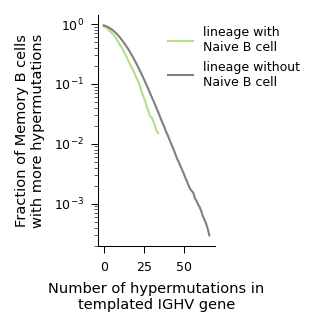

In [ ]:
relevant_df = df_clean
fig, ax = plt.subplots(figsize=(1,2))
for ct, dark_col in [('Memory B cells','g')]:
    naive_lineage_memB = relevant_df[(relevant_df.celltype=='Memory B cells') & relevant_df.naive_lineage].v_mismatch
    non_naive_lineage_memB = relevant_df[(relevant_df.celltype=='Memory B cells') & ~(relevant_df.naive_lineage.astype(bool))].v_mismatch
    
    counts_nl, bins = np.histogram(naive_lineage_memB, bins=np.arange(0,80)-0.5)
    total_nl_cells = len(naive_lineage_memB)
    print(total_nl_cells)
    log_data_ccdf = np.log(1- counts_nl.cumsum()/counts_nl.sum())
    cutoff_nl = np.argwhere(log_data_ccdf < np.log(20/total_nl_cells))[0][0]

    counts_nn, bins = np.histogram(non_naive_lineage_memB, bins=np.arange(0,80)-0.5)
    total_nn_cells = len(non_naive_lineage_memB)
    print(total_nn_cells)
    log_data_ccdf = np.log(1- counts_nn.cumsum()/counts_nn.sum())
    cutoff_nn = np.argwhere(log_data_ccdf < np.log(20/total_nn_cells))[0][0]
    bin_centers = (bins[1:] + bins[:-1])/2.

    ax.plot(bin_centers[:cutoff_nl], (1- counts_nl.cumsum()/counts_nl.sum())[:cutoff_nl], color=bcelltype_colors_alt['Naive B cells'], label='lineage with\nNaive B cell')
    ax.plot(bin_centers[:cutoff_nn], (1- counts_nn.cumsum()/counts_nn.sum())[:cutoff_nn], color='0.5', label='lineage without\nNaive B cell')
ax.legend(loc='upper left', bbox_to_anchor=(0.5,1), frameon=False)
ax.set_yscale('log')
ax.set_ylabel('Fraction of Memory B cells\nwith more hypermutations')
ax.set_xlabel('Number of hypermutations in\ntemplated IGHV gene')
sns.despine(fig)
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure8/naive_lineage_hypermutation.pdf', bbox_inches='tight')

In [ ]:
all_dist = df_clean.tissue.value_counts(normalize=True)
naive_dist = df_clean[df_clean.celltype=='Naive B cells'].tissue.value_counts(normalize=True)
hm_naive_dist = df_hm_clean[(df_hm_clean.celltype=='Naive B cells') & (df_hm_clean.v_mismatch < 30)].tissue.value_counts(normalize=True)

# calculate marginal celltype distributions for cells with GEX

In [ ]:
best_fit_model = p_celltype_norm
best_fit_model.index = best_fit_model.index.astype(int)
best_fit_model = best_fit_model.iloc[1:,:]


In [ ]:
empirical_distribution = df_hm_clean.groupby(['v_mismatch','celltype'])['vdj_sequence'].nunique().reset_index()
empirical_distribution['v_mismatch'] = empirical_distribution['v_mismatch'].astype(int)
empirical_distribution = empirical_distribution.pivot(index='v_mismatch', columns='celltype', values='vdj_sequence').fillna(0)
empirical_distribution = empirical_distribution[best_fit_model.columns]
total = empirical_distribution.sum(axis=1)
for col in empirical_distribution.columns:
    empirical_distribution[col] = (empirical_distribution[col]/total)
empirical_distribution

celltype,Memory B cells,ASC-4,ASC-3,ASC-2,ASC-1
v_mismatch,,,,,
1,0.956555,0.001524,0.030488,0.001524,0.009909
2,0.950350,0.001752,0.030958,0.005257,0.011682
3,0.955623,0.000504,0.028744,0.001513,0.013616
4,0.953909,0.000823,0.027160,0.003704,0.014403
5,0.954836,0.000376,0.026722,0.004893,0.013173
...,...,...,...,...,...
87,1.000000,0.000000,0.000000,0.000000,0.000000
88,0.000000,0.000000,0.000000,0.000000,1.000000
89,0.000000,0.000000,0.500000,0.500000,0.000000


In [ ]:
df_hm_clean['lineage_uid'] = df_hm_clean['donor'] + "_" + df_hm_clean['lineage_id'].fillna("").astype(str)

empirical_prob_df = df_hm_clean.groupby(['vdj_sequence','v_mismatch', 'lineage_uid', 'celltype','cb']).size()
lineage_sizes = df_hm_clean.groupby('lineage_uid')['vdj_sequence'].nunique()

empirical_prob_df = empirical_prob_df.reset_index()

for col in empirical_distribution:
    empirical_prob_df[col] = empirical_prob_df.apply(lambda x: empirical_distribution.loc[x.v_mismatch, col], axis=1)

In [ ]:
def prob_any(l):
    probabilities = np.asarray(list(l))
    return 1 - np.product(1.-probabilities)

def expectation(l):
    probabilities = np.asarray(list(l))
    return np.sum(probabilities)

In [ ]:
prob_any_in_lineage = empirical_prob_df.groupby(['lineage_uid'])[[col for col in empirical_distribution.columns]].agg(prob_any)
expected_cells_model = empirical_prob_df.groupby(['lineage_uid'])[[col for col in empirical_distribution.columns]].agg(expectation)
expected_cells_model['lineage_size'] = expected_cells_model.index.map(lineage_sizes)
expected_cells_model['lineage_size_binned'] = 2**round(np.log(expected_cells_model.lineage_size)/np.log(2))
expected_cells_model = expected_cells_model.groupby('lineage_size_binned').sum()
print(prob_any_in_lineage.sum())

Memory B cells    58147.614163
ASC-4               131.029467
ASC-3              5733.315747
ASC-2              1554.303071
ASC-1              5338.164688
dtype: float64


In [ ]:
empirical_count_any = empirical_prob_df.groupby(['lineage_uid','celltype']).size()
empirical_count_any = empirical_count_any.reset_index().pivot(index=['lineage_uid'], columns='celltype', values=0)
expected_cells_data = empirical_count_any.copy()
expected_cells_data['lineage_size'] = expected_cells_data.index.map(lineage_sizes)
expected_cells_data['lineage_size_binned'] = 2**round(np.log(expected_cells_data.lineage_size)/np.log(2))
expected_cells_data = expected_cells_data.groupby('lineage_size_binned').sum()
empirical_count_any = empirical_count_any > 0
empirical_count_any.sum(axis=0)


celltype
ASC-1              4908
ASC-2              1416
ASC-3              4350
ASC-4               124
Memory B cells    58536
dtype: int64

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/2330671015.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_95236/2330671015.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


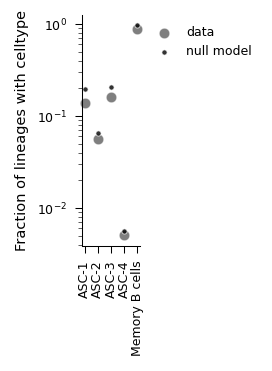

In [ ]:
fig, ax = plt.subplots(figsize=(0.5,2))
at_least_2 = empirical_count_any.index.map(lineage_sizes) > 1
n_lineages = at_least_2.sum()
g=sns.scatterplot(empirical_count_any[at_least_2].sum(axis=0)/n_lineages, marker='o', color='k', label='data', ax=ax, alpha=0.5, clip_on=False)
at_least_2 = prob_any_in_lineage.index.map(lineage_sizes) > 1
n_lineages = at_least_2.sum()
sns.scatterplot(prob_any_in_lineage[at_least_2].sum(axis=0)/n_lineages, marker='.', color='k', label='null model', ax=ax, alpha=0.8, clip_on=False)

sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_ylim([10,10**4])
sns.despine(fig)
ax.set_ylabel('Fraction of lineages with celltype')
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/Figure5/lineage_compostion_celltype_any_cells.pdf', bbox_inches='tight')

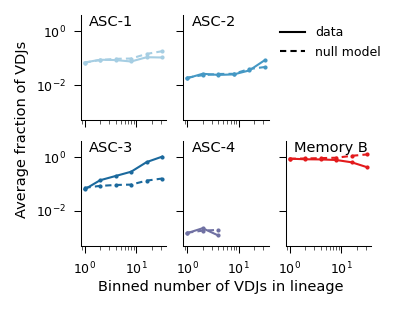

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(2.5,2), sharex=True, sharey=True)
axes = axes.flatten()

axes[2].remove()
axes = [axes[0], axes[1], axes[3], axes[4], axes[5]]
# axes = axes
i = 0

filter_on = (2**np.round(np.log(lineage_sizes)/np.log(2))).value_counts() > 10
for col in expected_cells_data.columns:
    if col == 'lineage_size':
        continue
    else:
        ax = axes[i]
        i+=1
    title = col.strip('cells') #col.split(" ")[0]+ + " ".join(col.split(" ")[1:])
    ax.text(0.1,1.,title, transform=ax.transAxes,fontsize=7,va='top', ha='left')
    filter_on = ((2**np.round(np.log(lineage_sizes)/np.log(2))).value_counts() > 10) & (expected_cells_data[col] > 5)
    ax.plot(expected_cells_data.loc[filter_on,col]/expected_cells_data.loc[filter_on,'lineage_size'],'o-', color=bcelltype_colors_alt[col],markersize=1)
    line1, = ax.plot(expected_cells_model.loc[filter_on, col]/expected_cells_model.loc[filter_on, 'lineage_size'],'o-', color=bcelltype_colors_alt[col],markersize=1)
    line1.set_dashes((3,2))
    ax.set_yscale('log')
    ax.set_xscale('log')
fig.supxlabel('Binned number of VDJs in lineage', fontsize=7, y = -0.05)
fig.supylabel('Average fraction of VDJs', fontsize=7, x=-0.05)
axes[1].plot([],[], color='k', label='data')
line1,  = axes[1].plot([],[], color='k', label='null model')
line1.set_dashes((3,2))
axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
sns.despine(fig)
axes[1].set_ylim([.5*10**-3,4])
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/Figure5/lineage_compostion_celltype_total_cells.pdf', bbox_inches='tight')
